In [ ]:
from torchvision import datasets
import torch
data_folder = '~/data/FMNIST' # This can be any directory # you want to download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True,train=True)
#Another way of downloading the dataset using OS

#import os
#from torchvision import datasets

#home_directory = os.path.expanduser('~')
#data_folder = os.path.join(home_directory, 'data', 'FMNIST')

#fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)


Dataset loaded & downloaded in our memory

In [ ]:
tr_images = fmnist.data
tr_targets = fmnist.targets

For random selection of images from each class,

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

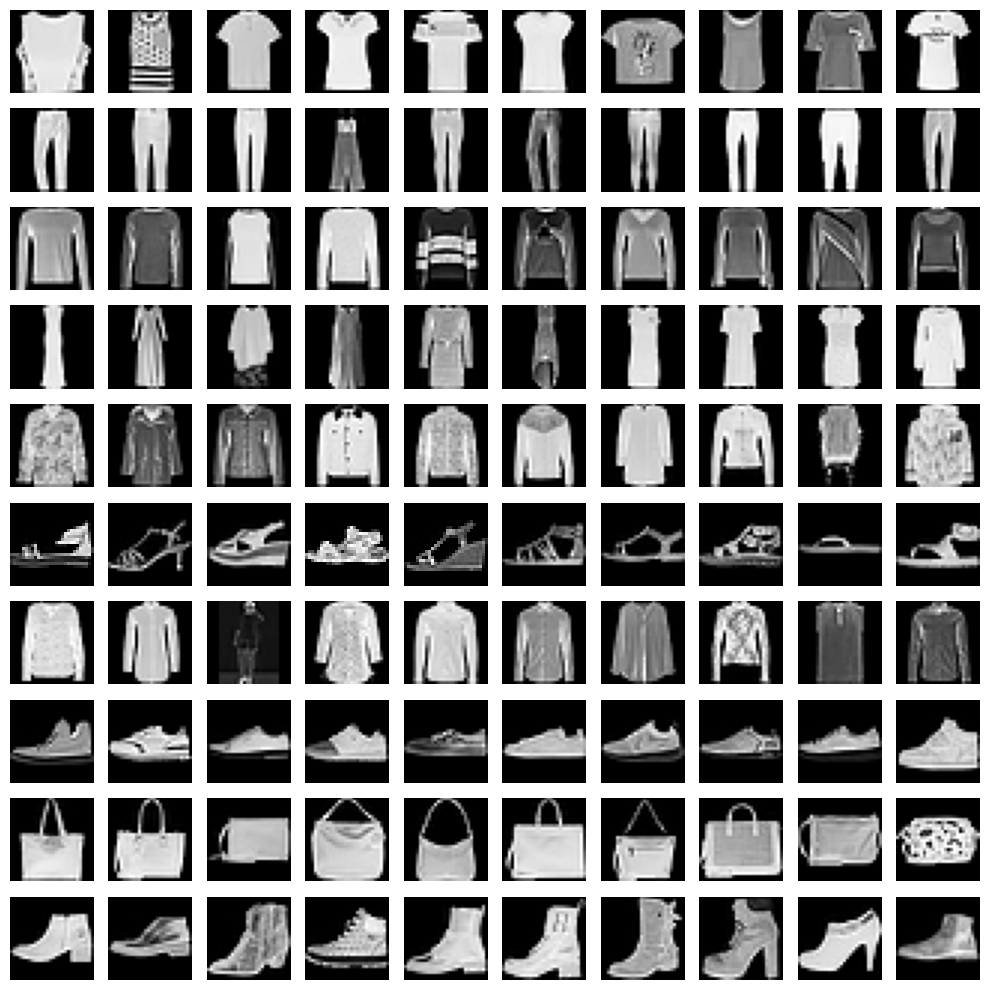

In [ ]:
R, C = len(tr_targets.unique()), 10
fig, ax = plt.subplots(R, C, figsize=(10,10))
for label_class, plot_row in enumerate(ax):
  label_x_rows = np.where(tr_targets == label_class)[0]
  for plot_cell in plot_row:
    plot_cell.grid(False); plot_cell.axis('off')
    ix = np.random.choice(label_x_rows)
    x, y = tr_images[ix], tr_targets[ix]
    plot_cell.imshow(x, cmap='gray')
plt.tight_layout()

Converting images to tensors

In [ ]:
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
from torchvision import datasets
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#print(device) to check  if GPU is loaded or not

Dataset Code

In [ ]:
class FMNISTDataset(Dataset):
  def __init__(self,x,y):
    x = x.float()
    x = x.view(-1,28*28)#flattening the image
    self.x,self.y = x,y

  def __getitem__(self,idx):
    x,y = self.x[idx],self.y[idx]
    return x.to(device),y.to(device)

  def __len__(self):
    return len(self.x)

# return images as tensors

Calling FMNISTDataset Class and loading it into the DataLoader

In [ ]:
def get_data():
  train = FMNISTDataset(tr_images,tr_targets)
  trn_dl = DataLoader(train, batch_size =32 , shuffle = True)
  return trn_dl

Architecture of the NN

In [ ]:
from torch.optim import SGD

def get_model():
  model = nn.Sequential(
      nn.Linear(28*28,1000),#input layer
      nn.ReLU(),
      nn.Linear(1000,10) #output linear layer with 10 classes
  ).to(device)
  loss_func = nn.CrossEntropyLoss() # since this is a multi-class classification problem
  opt = SGD(model.parameters(),lr = 1e-2)
  return model,loss_func,opt

Evaluation metrics--> Accuracy Calculation for a single batch

In [ ]:
@torch.no_grad() #removes or deactivates gradients as they are not needed here (saves memory , time)

def accuracy(x,y,model):
  model.eval() #as in model.train() for training, this is for evaluation

  prediction = model(x)
  max_values,argmaxes = prediction.max(-1) #returns 2 tensors--> max_values(has the max value),argmaxes(has the indices of max values)
  #where max(-1) indicates the maximum value along the last dimension of the tensor

  is_correct = argmaxes==y
  return is_correct.cpu().numpy().tolist()

Training Loop for a single batch to get Loss

In [ ]:
def train_batch(x,y,model,optimizer,loss_func):
  model.train()

  prediction = model(x)
  loss_value = loss_func(prediction,y)
  loss_value.backward()

  opt.step()
  opt.zero_grad()
  return loss_value.item()


Function Call

In [ ]:
trn_dl = get_data()
model,loss_func,opt = get_model()

Training loop for every batch loss, accuracy

In [ ]:
losses, accuracies = [], []

for epoch in range(5):
  print(epoch)
  epoch_losses,epoch_accuracies = [], []

  #for losses
  for ix,batch in enumerate(iter(trn_dl)):
    x,y = batch
    loss_value = train_batch(x,y,model,opt,loss_func)
    epoch_losses.append(loss_value)
  epoch_loss = np.array(epoch_losses).mean()

  #for accuracies
  for ix,batch in enumerate(iter(trn_dl)):
    x,y = batch
    is_correct = accuracy(x,y,model)
    epoch_accuracies.append(is_correct)
  epoch_accuracy = np.mean(epoch_accuracies)

  losses.append(epoch_loss)
  accuracies.append(epoch_accuracy)

0
1
2
3
4


Plotting loss and accuracy

<ipython-input-24-07f3345cba83>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


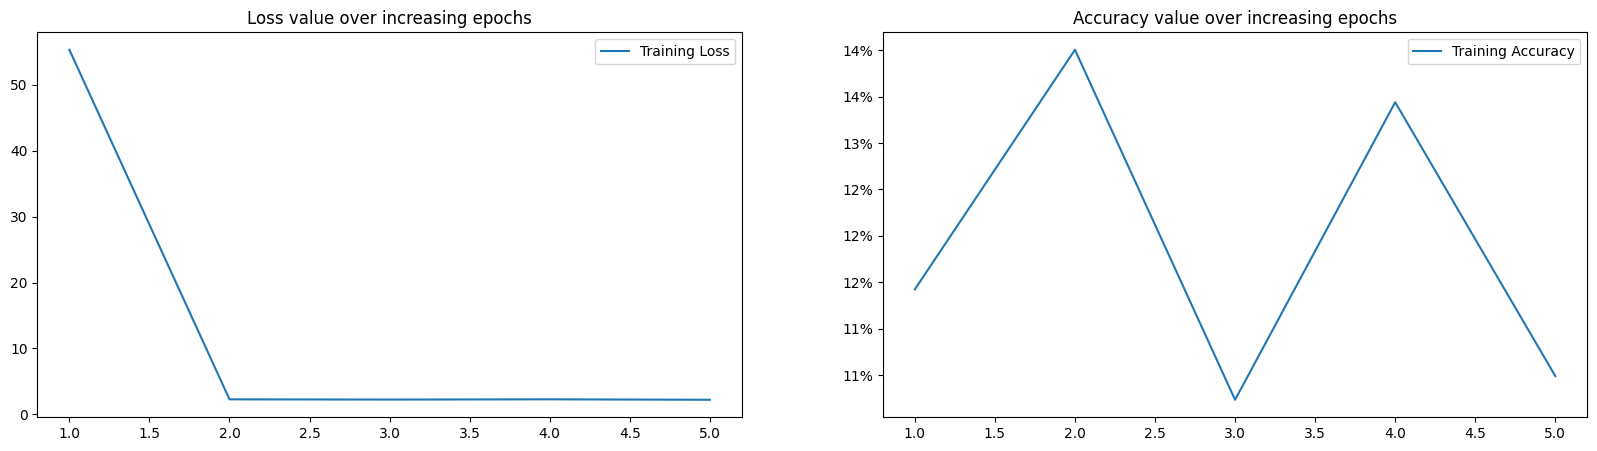

In [ ]:
epochs = np.arange(5)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()